# 🏴‍☠️ Pirate Pain Classification Challenge

> ⚓ *"Even pirates feel pain — let's teach the model to feel it too."*

---

## 📚 Table of Contents
0. [README](#readme)  
1. [Setup & Configuration](#setup)  
2. [Data Loading](#data-loading)  
3. [Import Libraries](#import-libraries)  
4. [Data Preprocessing](#data-preprocessing)  
5. [Sequence Building](#sequence-building)  
6. [DataLoaders](#dataloaders)  
7. [Model Architecture](#model-architecture)  
8. [Network Hyperparameters](#hyperparameters)  
9. [Training Functions](#training-functions)  
10. [Model Training](#model-training)  
11. [Evaluation & Metrics](#evaluation)  
12. [Model Loading & Final Testing](#model-loading)  
13. [Competition Submission](#submission)

---

### ⚙️ Quick Configuration Map

> 🧭 *"If ye seek to tweak the code, here be where to look!"*

- 🧺 **Batch Size:** → [DataLoaders](#dataloaders)  
- ⚗️ **Hyperparameters:** → [Network Hyperparameters](#hyperparameters)  
- 🪞 **Window Size & Stride:** → [Sequence Building](#sequence-building)  
- ⚙️ **Model Type:** → [Setup & Configuration](#setup)  

---



---

### 💰 Treasure Storage — Models & Submissions
> 🏴‍☠️ *"A wise pirate always knows where his treasure be buried — guard yer models and submissions well!"*

- 💾 **Model & Submission Save/Load Path:** → [Setup & Configuration](#setup)  
  - 🗂️ Models be saved in a **`models/`** folder with the name:
    **`experiment_name_dd-mm-HH-MM.pt`** (day-month-hour-minute).
  - 📜 Submissions be saved in a **`submissions/`** folder with the filename format:  
    **`experiment_name_dd-mm-HH-MM.csv`** .
  - 🔡 All related model parameters are saved in **`models/`** folder with the  name **`experiment_name_dd-mm-HH-MM_config.json`** .

  
  *❗The experiment name is set as **`RnnType_Bi_dd-mm-HH-MM`** or **`RnnType_dd-mm-HH-MM`** depending on if it is bidirectional or not*
---






<a id="readme"></a>
## 0. Info



This section lists all the main parameters that can be modified to control data loading, model behavior, and training.

---

### 📁 File Paths
| Variable | Description | Default Value |
|-----------|--------------|----------------|
| `TRAIN_DATA_PATH` | Training features | `'pirate_pain_train.csv'` |
| `TRAIN_LABELS_PATH` | Training labels | `'pirate_pain_train_labels.csv'` |
| `TEST_DATA_PATH` | Test set for inference | `'pirate_pain_test.csv'` *(optional)* |
| `MODEL_SAVE_PATH` | Output model file | `'pirate_model.pt'` |
| `RESULTS_FILE` | CSV for predictions | `'results_<date-time>.csv'` |

---

### 🧠 Model & Architecture
| Parameter | Description | Typical Values |
|------------|--------------|----------------|
| `model_type` | Choose model class | `'RNN'`, `'LSTM'`, `'GRU'`, `'ANN'` |
| `input_size` | Number of features per time step | *auto-detected from data* |
| `hidden_size` | Hidden layer size | `64`, `128`, `256` |
| `num_layers` | Number of RNN layers | `1-4` |
| `dropout` | Dropout probability | `0.2–0.5` |
| `num_classes` | Output classes (pain levels) | *from label set* |

---

### 🏋️ Training Hyperparameters
| Parameter | Description | Default / Range |
|------------|--------------|-----------------|
| `batch_size` | Samples per batch | `512/2^n` |
| `learning_rate` | Optimizer learning rate | `1e-3` |
| `num_epochs` | Training iterations | `500` |
| `optimizer` | Optimization algorithm | `'AdamW'` |
| `criterion` | Loss function | `CrossEntropyLoss()` |
| `seed` | Random seed for reproducibility | `42` |

---

### 📤 Inference
| Parameter | Description |
|------------|--------------|
| `LOAD_MODEL_PATH` | Path to pretrained `.pt` model (optional) |
| `save_results` | Whether to write output CSV | `True` |

---

> 💡 *Tip:* Adjust hyperparameters in the “Configuration” or “Training Setup” cell before running the notebook.


<a id="setup"></a>
## 1. Setup & Configuration

*Optional: Connect to Google Drive (for Colab users)*

In [1]:
from google.colab import drive
drive.mount("/gdrive")
current_dir = "/gdrive/MyDrive/pirate_dataset"
%cd $current_dir

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/pirate_dataset


*Set Model Type*

In [2]:
RNN_TYPE = 'LSTM'            # 'RNN', 'LSTM', or 'GRU'
BIDIRECTIONAL = True        # True / False

*Set Model Save Name*

In [3]:
from datetime import datetime

# Get current date and time for submission filename
current_datetime = datetime.now().strftime("%d-%m-%H-%M")

if BIDIRECTIONAL:
    EXPERIMENT_NAME = f"{RNN_TYPE}_bi_{current_datetime}"
else:
    EXPERIMENT_NAME = f"{RNN_TYPE}_{current_datetime}"

SUBMISSION_FILENAME = f"{EXPERIMENT_NAME}.csv"
print(f"Experiment name: {EXPERIMENT_NAME}")
print(f"Submission filename: {SUBMISSION_FILENAME}")

Experiment name: LSTM_bi_10-11-21-03
Submission filename: LSTM_bi_10-11-21-03.csv


<a id="data-loading"></a>
## 2. Data Loading

Load training and test datasets from CSV files.

In [4]:
import pandas as pd

X_train = pd.read_csv('pirate_pain_train.csv')
y_train = pd.read_csv('pirate_pain_train_labels.csv')

<a id="import-libraries"></a>
## 3. Import Libraries

Set random seeds for reproducibility and import all necessary packages.

In [5]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import ParameterGrid

# Directory configuration
logs_dir = "tensorboard"
models_dir = "models"



# Model save/load paths
MODEL_SAVE_PATH = f"{models_dir}/{EXPERIMENT_NAME}_model.pt"
MODEL_LOAD_PATH = f"{models_dir}/{EXPERIMENT_NAME}_model.pt"

!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p {models_dir}

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from datetime import datetime
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

PyTorch version: 2.8.0+cu126
Device: cuda


<a id="data-preprocessing"></a>
## 4. Data Preprocessing

Explore data, split into train/val/test sets, normalize features, and encode labels.

In [6]:
# Print the shape of the dataset
print(f"Dataset shape: {X_train.shape}")

# Display the first few rows of the dataset
X_train.head(2)

Dataset shape: (105760, 40)


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,0,2,1,two,two,two,1.094705,...,3.499558e-06,1.945042e-06,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5
1,0,1,2,2,2,2,two,two,two,1.135183,...,3.976952e-07,6.765107e-07,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5


### 4.1 Data Exploration

In [7]:
# Merge features and labels
data = X_train.merge(y_train, on='sample_index')

# Create a mapping dictionary to convert categorical labels to numerical values
map_dict = {'none': 0, 'one': 1, 'two': 2}
data['n_legs'] = data['n_legs'].map(map_dict)
data['n_hands'] = data['n_hands'].map(map_dict)
data['n_eyes'] = data['n_eyes'].map(map_dict)


### 4.2 Categorical Encoding

In [8]:
import pandas as pd
import random
from sklearn.model_selection import train_test_split

# df has columns: ['sample_index', 'label']
N_VAL_USERS = 30
N_TEST_USERS = 0

# --- Step 1: Compute each user's dominant label (or label distribution)
user_labels = (
    data.groupby('sample_index')['label']
    .agg(lambda x: x.value_counts().index[0])  # dominant label per user
    .reset_index()
)

train_users, temp_users = train_test_split(
    user_labels['sample_index'],
    test_size=(N_VAL_USERS + N_TEST_USERS) / len(user_labels),
    stratify=user_labels['label'],
    random_state=SEED
)

# Split temp into val/test (also stratified)
temp_labels = user_labels[user_labels['sample_index'].isin(temp_users)]
if N_TEST_USERS != 0:
  val_users, test_users = train_test_split(
      temp_labels['sample_index'],
      test_size=N_TEST_USERS / (N_VAL_USERS + N_TEST_USERS),
      stratify=temp_labels['label'],
      random_state=SEED
  )
else:
  val_users = temp_users
  test_users = []

# --- Step 3: Filter your main df
df_train = data[data['sample_index'].isin(train_users)]
df_val = data[data['sample_index'].isin(val_users)]
df_test = data[data['sample_index'].isin(test_users)]

# --- Step 4: Check label proportions
print("Label proportions:")
print("Train:\n", df_train['label'].value_counts(normalize=True))
print("Val:\n", df_val['label'].value_counts(normalize=True))
print("Test:\n", df_test['label'].value_counts(normalize=True))

Label proportions:
Train:
 label
no_pain      0.773376
low_pain     0.142631
high_pain    0.083994
Name: proportion, dtype: float64
Val:
 label
no_pain      0.766667
low_pain     0.133333
high_pain    0.100000
Name: proportion, dtype: float64
Test:
 Series([], Name: proportion, dtype: float64)


### 4.3 Stratified Train/Val/Test Split

In [9]:
df_train.shape, df_val.shape, df_test.shape

((100960, 41), (4800, 41), (0, 41))

In [10]:
# Print the total number of pirates for each dataset
print(f"Total pirates in training set: {df_train['sample_index'].nunique()}")
print(f"Total pirates in validation set: {df_val['sample_index'].nunique()}")
print(f"Total pirates in test set: {df_test['sample_index'].nunique()}")

Total pirates in training set: 631
Total pirates in validation set: 30
Total pirates in test set: 0


In [11]:
# Define the columns to be normalised
scale_columns = [col for col in data.columns
                 if (col.startswith('joint_') or col.startswith('pain_survey')) and not col.startswith('joint_30')]

# Calculate the minimum and maximum values from the training data only
mins_train = df_train[scale_columns].min()
maxs_train = df_train[scale_columns].max()

mins_val = df_val[scale_columns].min()
maxs_val = df_val[scale_columns].max()

mins_test = df_test[scale_columns].min()
maxs_test = df_test[scale_columns].max()


# Apply normalisation to the specified columns in all datasets
for column in scale_columns:
    # Normalise the training set
    df_train[column] = (df_train[column] - mins_train[column]) / (maxs_train[column] - mins_train[column])

    # Normalise the validation set
    df_val[column] = (df_val[column] - mins_val[column]) / (maxs_val[column] - mins_val[column])

    # Normalise the test set
    df_test[column] = (df_test[column] - mins_test[column]) / (maxs_test[column] - mins_test[column])


### 4.4 Feature Normalization

In [12]:
# Initialise a dictionary to count occurrences of each activity in the training set
training_labels = {
    'no_pain': 0,
    'low_pain': 0,
    'high_pain': 0
}

# Count occurrences of each activity for unique IDs in the training set
for id in df_train['sample_index'].unique():
    label = df_train[df_train['sample_index'] == id]['label'].values[0]
    training_labels[label] += 1


#if 'joint_30' in df_train.columns:
#    df_train = df_train.drop(columns=['joint_30']) # we deleted this joint since has no final effect during training

# Print the distribution of training labels
print('Training labels:', training_labels)

# Initialise a dictionary to count occurrences of each activity in the training set
val_labels = {
    'no_pain': 0,
    'low_pain': 0,
    'high_pain': 0
}

# Count occurrences of each activity for unique IDs in the training set
for id in df_val['sample_index'].unique():
    label = df_val[df_val['sample_index'] == id]['label'].values[0]
    val_labels[label] += 1


#if 'joint_30' in df_val.columns:
#    df_val = df_val.drop(columns=['joint_30']) # we deleted this joint since has no final effect during training

# Print the distribution of validation labels
print('Validation labels:', val_labels)

# Initialise a dictionary to count occurrences of each activity in the test set
test_labels = {
    'no_pain': 0,
    'low_pain': 0,
    'high_pain': 0
}

# Count occurrences of each activity for unique IDs in the test set
for id in df_test['sample_index'].unique():
    label = df_test[df_test['sample_index'] == id]['label'].values[0]
    test_labels[label] += 1
#if 'joint_30' in df_test.columns:
#    df_test = df_test.drop(columns=['joint_30']) # we deleted this joint since has no final effect during training

# Print the distribution of test labels
print('Test labels:', test_labels)

Training labels: {'no_pain': 488, 'low_pain': 90, 'high_pain': 53}
Validation labels: {'no_pain': 23, 'low_pain': 4, 'high_pain': 3}
Test labels: {'no_pain': 0, 'low_pain': 0, 'high_pain': 0}


### 4.5 Label Distribution Analysis

In [13]:
# Define a training mapping of label names to integer labels
train_label_mapping = {
    'no_pain': 0,
    'low_pain': 1,
    'high_pain': 2
}

# Map label names to integers in the training set
df_train['label'] = df_train['label'].map(train_label_mapping)

# Define a validation mapping of label names to integer labels
val_label_mapping = {
    'no_pain': 0,
    'low_pain': 1,
    'high_pain': 2
}

# Map label names to integers in the validation set
df_val['label'] = df_val['label'].map(val_label_mapping)

test_label_mapping = {
    'no_pain': 0,
    'low_pain': 1,
    'high_pain': 2
}

# Map label names to integers in the test set
df_test['label'] = df_test['label'].map(test_label_mapping)


<a id="sequence-building"></a>
## 5. Sequence Building

Convert variable-length time-series into fixed-size windows for RNN input.

In [14]:

# Define window and stride boolean variable -> if True, during training we will visit more time the same pirate with overlapping windows
# if False, each pirate will be visited only once during training
one_pirate_window = True

In [15]:
if one_pirate_window:
    # Define the window size
    WINDOW_SIZE = 80 # before: 80

    # Stride size
    STRIDE = 5
else:
    # Define the window size -> select an higher window size in order to get more pirates
    WINDOW_SIZE = 160

    # Stride size
    STRIDE = 160

### 5.1 Window & Stride Configuration

In [16]:
"""
  GENERAL COMMENTS:
  in this function we are restricting for each user data the number of samples of recorded data to a constant
  value (window size), since every user data could be composed by different numbers of timestep. Therefore we are
  "normalizing" the timesteps of a constant window size. Additionally is also defined a stride variable, which if is equal to
  the window size, then we are not taking overlapping timestamp samples, instead if stride < window, we are letting some samples
  to overlap in such a way that the RNN or other kind of NN architecture will analyze better the context.
"""

# Define a function to build sequences from the dataset
def build_sequences(df, window=200, stride=200):
    # Sanity check to ensure the window is divisible by the stride
    assert window % stride == 0 # checks if the window size is divisible by the stride

    # Initialise lists to store sequences and their corresponding labels
    dataset = []
    labels = []

    # Iterate over unique IDs in the DataFrame
    for id in df['sample_index'].unique():

        # Extract pirate sample index data for the current sample index
        columns = [col for col in df.columns if col not in ['sample_index', 'label', 'time']]

        temp = df[df['sample_index'] == id][columns].values

        # Retrieve the label for the current pirate
        label = df[df['sample_index'] == id]['label'].values[0]

        # Calculate padding length to ensure full windows
        padding_len = window - len(temp) % window

        # Create zero padding and concatenate with the data
        padding = np.zeros((padding_len, len(columns)), dtype='float32')
        temp = np.concatenate((temp, padding))

        # Build feature windows and associate them with labels
        idx = 0
        while idx + window <= len(temp):
            dataset.append(temp[idx:idx + window])
            labels.append(label)
            idx += stride

    # Convert lists to numpy arrays for further processing
    dataset = np.array(dataset)
    labels = np.array(labels)

    return dataset, labels

### 5.2 Build Sequences Function

In [17]:
# Generate sequences and labels for the training set
X_train, y_train = build_sequences(df_train, WINDOW_SIZE, STRIDE)

# Generate sequences and labels for the validation set
X_val, y_val = build_sequences(df_val, WINDOW_SIZE, STRIDE)

# Generate sequences and labels for the test set
X_test, y_test = build_sequences(df_test, WINDOW_SIZE, STRIDE)

# Print the shapes of the generated datasets and their labels
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((20823, 80, 38), (20823,), (990, 80, 38), (990,), (0,), (0,))

### 5.3 Generate Sequences for Train/Val/Test

In [18]:
# Convert dataset into float32 for PyTorch compatibility
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')
# y_train = y_train.astype('int64')
# y_val = y_val.astype('int64')
# y_test = y_test.astype('int64')

### 5.4 Data Type Conversion & Cleaning

In [19]:
# Define the input shape based on the training data
input_shape = X_train.shape[1:]

# Define the number of classes based on the categorical labels
num_classes = len(np.unique(y_train))

In [20]:

# Discard nan values from the dataset
if np.isnan(X_train).any() or np.isnan(X_val).any() or np.isnan(X_test).any():
    X_train = np.nan_to_num(X_train)
    X_val = np.nan_to_num(X_val)
    X_test = np.nan_to_num(X_test)


In [21]:
# Convert numpy arrays to PyTorch datasets (pairs features with labels)
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_ds   = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_ds  = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

<a id="dataloaders"></a>
## 6. DataLoaders

Create PyTorch DataLoaders for efficient batching and parallel loading.

In [22]:
# Define the batch size, which is the number of samples in each batch
BATCH_SIZE = 512 # we can change it depending on the GPU RAM available (by default 512)

In [23]:
def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [24]:
# Create data loaders with different settings for each phase
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [25]:
# Get one batch from the training data loader
for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break # Stop after getting one batch

Features batch shape: torch.Size([512, 80, 38])
Labels batch shape: torch.Size([512])


In [26]:
def recurrent_summary(model, input_size):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create a dummy input tensor with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

<a id="hyperparameters"></a>
## 8. Network Hyperparameters

Configure training settings, architecture parameters, and regularization.

In [27]:
# # Training configuration
#LEARNING_RATE = 1e-3
#EPOCHS = 500
#PATIENCE = 40
#
## Architecture
#HIDDEN_LAYERS = 2        # Hidden layers
#HIDDEN_SIZE = 32        # Neurons per layer -> prev hidden size = 128
#
## Regularisation
#DROPOUT_RATE = 0.3       # Dropout probability
#
## For now disable weight decay
#L1_LAMBDA = 1.0          # L1 penalty
#L2_LAMBDA = 0.6            # L2 penalty
#
## Set up loss function and optimizer
#
#criterion = nn.CrossEntropyLoss()

In [28]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

<a id="model-architecture"></a>
## 7. Model Architecture

Custom RNN/LSTM/GRU classifier with configurable bidirectionality and dropout.

### 7.1 Recurrent Classifier Class

In [29]:
class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier (RNN, LSTM, GRU).
    Uses the last hidden state for classification.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type= RNN_TYPE,        # 'RNN', 'LSTM', or 'GRU'
            bidirectional=BIDIRECTIONAL,
            dropout_rate=0.2
            ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0 # dropout between RNN layers, applied for regularization

        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,       # Input shape: (batch, seq_len, features)
            bidirectional=bidirectional, # We are defining a bidirectional RNN since we want to extract also the future contextual information for making better predictions
            dropout=dropout_val
        )

        # Calculate input size for the final classifier
        if self.bidirectional:
            classifier_input_size = hidden_size * 2 # Concat fwd + bwd
        else:
            classifier_input_size = hidden_size

        # Final classification layer
        self.classifier = nn.Linear(classifier_input_size, num_classes) # output layer for classifying

    def forward(self, x):
        """
        x shape: (batch_size, seq_length, input_size)
        """

        # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
        rnn_out, hidden = self.rnn(x) # feeds the input sequence into the RNN layer
        # rnn_out -> contains the hidden state output for every timestep

        # LSTM returns (h_n, c_n), we only need h_n
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]  # final hidden state of the last timestep

        # hidden shape: (num_layers * num_directions, batch_size, hidden_size)

        if self.bidirectional:
            # Reshape to (num_layers, 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)

            # Concat last fwd (hidden[-1, 0, ...]) and bwd (hidden[-1, 1, ...])
            # Final shape: (batch_size, hidden_size * 2)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            # Take the last layer's hidden state
            # Final shape: (batch_size, hidden_size)
            hidden_to_classify = hidden[-1]

        # Get logits
        logits = self.classifier(hidden_to_classify)
        return logits

<a id="training-functions"></a>
## 9. Training Functions

Helper functions for training, validation, logging, and early stopping.

### 9.1 Train One Epoch Function

In [30]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

### 9.2 Validate One Epoch Function

In [31]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

### 9.3 Tensorboard Logging Function

In [32]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

### 9.4 Fit Function

In [33]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name="",save_model=True):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement :
                best_metric = current_metric
                best_epoch = epoch
                if save_model:
                  torch.save(model.state_dict(), f"{models_dir}/{experiment_name}_model.pt")
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0 and save_model:
        model.load_state_dict(torch.load(f"{models_dir}/{experiment_name}_model.pt"))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0 and save_model:
        torch.save(model.state_dict(), f"{models_dir}/{experiment_name}_model.pt")
    if not save_model:
        print("Model saving turned off.")

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

### 9.4 Main Fit Function (Grid Loop)

#### 9.4.1 Set Parameter Grid

In [34]:
GRID_EPOCHS = 100
GRID_PATIENCE = 20
param_grid = {
    'HIDDEN_SIZE': [64],
    'HIDDEN_LAYERS': [2],
    'LEARNING_RATE': [1e-3],
    'DROPOUT_RATE': [0.3],
    'BATCH_SIZE': [512],
    'L1_LAMBDA': [0.0001],
    'L2_LAMBDA': [0.001],
    'WINDOW': [80],
    'STRIDE': [10],
    'WEIGHTS': [[1.0, 1.0, 1.0], [0.8, 1.0, 1.0], [0.5, 1.0, 1.0]]
}

results = []
grid = list(ParameterGrid(param_grid))

#### 9.4.2 Loop The Grid

In [35]:
%%time
print(f'Running {len(grid)} configurations...')

import os, math, copy, time

# --- ensure output directories exist ---
os.makedirs(str(logs_dir), exist_ok=True)

best_val_f1 = float('-inf')
best_params = None
best_training_history = None
best_state_dict = None
best_model_path = None
best_run_idx = None
best_epoch_in_run = None
results = []


for idx, params in enumerate(grid, 1):
    start_time = time.perf_counter()
    print(f"\nConfiguration {idx}/{len(grid)}: {params}")
    #Set up Criterion
    weights = torch.tensor(params['WEIGHTS']).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights)
    #Build Sequence for the grid step
    WINDOW_GRID = params['WINDOW']
    STRIDE_GRID = params['STRIDE']
    # Generate sequences and labels for the training set
    X_train, y_train = build_sequences(df_train, WINDOW_GRID, STRIDE_GRID)
    # Generate sequences and labels for the validation set
    X_val, y_val = build_sequences(df_val, WINDOW_GRID, STRIDE_GRID)
    X_train = X_train.astype('float32')
    X_val = X_val.astype('float32')
    # Define the input shape based on the training data
    input_shape = X_train.shape[1:]
    # Define the number of classes based on the categorical labels
    num_classes = len(np.unique(y_train))
    # Discard nan values from the dataset
    if np.isnan(X_train).any() or np.isnan(X_val).any() or np.isnan(X_test).any():
        X_train = np.nan_to_num(X_train)
        X_val = np.nan_to_num(X_val)
    train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    val_ds   = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
    train_loader = make_loader(train_ds, batch_size=params['BATCH_SIZE'], shuffle=True, drop_last=False)
    val_loader   = make_loader(val_ds, batch_size=params['BATCH_SIZE'], shuffle=False, drop_last=False)
    print(f"Training set size: {len(train_ds)}")
    print(f"Validation set size: {len(val_ds)}")


    # Build model
    rnn_model = RecurrentClassifier(
        input_size=input_shape[-1],
        hidden_size=params['HIDDEN_SIZE'],
        num_layers=params['HIDDEN_LAYERS'],
        num_classes=num_classes,
        dropout_rate=params['DROPOUT_RATE'],
        bidirectional=BIDIRECTIONAL,
        rnn_type=RNN_TYPE
    ).to(device)

    # Display architecture summary
    try:
        recurrent_summary(rnn_model, input_size=input_shape)
    except Exception as e:
        print(f"[warn] recurrent_summary failed: {e}")

    # Set up TensorBoard writer
    experiment_id = f"{EXPERIMENT_NAME}_{idx}"
    writer = SummaryWriter(f"./{logs_dir}/{experiment_id}")

    # Add model graph only once to save time/disk
    if idx == 1:
        try:
            x = torch.randn(1, input_shape[0], input_shape[1]).to(device)
            x_for_graph = x if getattr(rnn_model, "batch_first", True) else x.permute(1, 0, 2)
            writer.add_graph(rnn_model, x_for_graph)
        except Exception as e:
            print(f"[warn] Skipping add_graph: {e}")

    # Optimizer and AMP scaler
    optimizer = torch.optim.AdamW(
        rnn_model.parameters(),
        lr=params['LEARNING_RATE'],
        weight_decay=params['L2_LAMBDA']
    )
    scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))

    # --- train model ---
    try:
        rnn_model, training_history = fit(
            model=rnn_model,
            train_loader=train_loader,
            val_loader=val_loader,
            l1_lambda=params['L1_LAMBDA'],
            l2_lambda=0.0, # Always set to zero because we are applying L2 Regularization in Optimizer
            epochs=GRID_EPOCHS,
            criterion=criterion,
            optimizer=optimizer,
            scaler=scaler,
            device=device,
            writer=None, # No Tensorboard saving
            verbose=10,
            experiment_name=experiment_id,
            patience=GRID_PATIENCE,
            save_model=False
        )

        # Extract metrics
        val_f1_series = [float(v) for v in training_history.get('val_f1', [])
                         if isinstance(v, (int, float)) and math.isfinite(v)]
        val_loss_series = [float(v) for v in training_history.get('val_loss', [])
                           if isinstance(v, (int, float)) and math.isfinite(v)]

        if val_f1_series and val_loss_series:
            run_best_f1 = max(val_f1_series)
            run_best_epoch = val_f1_series.index(run_best_f1) + 1
            run_best_val_loss = val_loss_series[run_best_epoch - 1]
            elapsed = time.perf_counter() - start_time

            print(f"[Run {idx}] Best val_f1 = {run_best_f1:.4f} (epoch {run_best_epoch})")

            # Save metrics for summary table
            results.append({
                'Run': idx,
                'Best_Epoch': run_best_epoch,
                'Best_Val_F1': run_best_f1,
                'Best_Val_Loss': run_best_val_loss,
                'Elapsed_s': elapsed,
                **params
            })

            # Track best model
            if run_best_f1 > best_val_f1:
                best_val_f1 = run_best_f1
                best_params = params
                best_training_history = training_history
                best_state_dict = copy.deepcopy(rnn_model.state_dict())
                best_run_idx = idx
                best_epoch_in_run = run_best_epoch
                #best_model_path = f"./{logs_dir}/{EXPERIMENT_NAME}_best.pt"
                #torch.save(best_state_dict, best_model_path)

        else:
            print("[warn] No valid val_f1 or val_loss values recorded for this run.")

    except Exception as e:
        print(f"[error] Training failed for configuration {idx}: {e}")

    finally:
        try:
            writer.close()
        except Exception:
            pass
        del optimizer, scaler, rnn_model
        if device.type == 'cuda':
            torch.cuda.empty_cache()

    print(f"Configuration {idx} completed in {time.perf_counter() - start_time:.1f}s")

# --- summary ---
print("\n" + "="*50)
print("                GRID SEARCH COMPLETE")
print("="*50)
if best_params is not None:
    print(f"Best run: #{best_run_idx} (epoch {best_epoch_in_run})")
    print(f"Best Validation F1 Score: {best_val_f1:.4f}")
    print(f"Best Parameters: {best_params}")
    if best_model_path:
        print(f"Best model saved to: {best_model_path}")
else:
    print("No successful runs (val_f1 was empty or invalid).")
print("="*50)

# --- results table ---
if results:
    df_results = pd.DataFrame(results)
    df_results = df_results.sort_values(by='Best_Val_F1', ascending=False).reset_index(drop=True)

    print("\nGrid Search Results Summary:")
    print(df_results.to_string(index=False))

    # Optionally save results to CSV
    results_path = f"./{logs_dir}/{EXPERIMENT_NAME}_grid_results.csv"
    df_results.to_csv(results_path, index=False)
    print(f"\nResults saved to: {results_path}")
else:
    print("No results to display.")

Running 3 configurations...

Configuration 1/3: {'BATCH_SIZE': 512, 'DROPOUT_RATE': 0.3, 'HIDDEN_LAYERS': 2, 'HIDDEN_SIZE': 64, 'L1_LAMBDA': 0.0001, 'L2_LAMBDA': 0.001, 'LEARNING_RATE': 0.001, 'STRIDE': 10, 'WEIGHTS': [1.0, 1.0, 1.0], 'WINDOW': 80}
Training set size: 10727
Validation set size: 510
-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (LSTM)                [[-1, 80, 128], [4, -1, 64]] 152,576        
classifier (Linear)       [-1, 3]                      387            
Total params: 152,963
Trainable params: 152,963
Non-trainable params: 0
-------------------------------------------------------------------------------
Training 100 epochs...
Epoch   1/100 | Train: Loss=1.7197, F1 Score=0.6448 | Val: Loss=0.7326, F1 Score=0.6654
Epoch  10/100 | Train: Loss=0.7415, F1 Score=0.6899 | Val: Loss=0.6744, F1 Score=0.6720
Epoch  20/100 | Train: Loss=0.5608, F1 Score=0.7788 | 

### 9.5 Results

In [36]:
results = pd.read_csv(results_path)
results

,Run,Best_Epoch,Best_Val_F1,Best_Val_Loss,Elapsed_s,BATCH_SIZE,DROPOUT_RATE,HIDDEN_LAYERS,HIDDEN_SIZE,L1_LAMBDA,L2_LAMBDA,LEARNING_RATE,STRIDE,WEIGHTS,WINDOW
0,3,29,0.901813,0.394514,36.191214,512,0.3,2,64,0.0001,0.001,0.001,10,"[0.5, 1.0, 1.0]",80
1,1,51,0.839580,0.373559,62.110815,512,0.3,2,64,0.0001,0.001,0.001,10,"[1.0, 1.0, 1.0]",80
2,2,23,0.830231,0.470533,30.286061,512,0.3,2,64,0.0001,0.001,0.001,10,"[0.8, 1.0, 1.0]",80


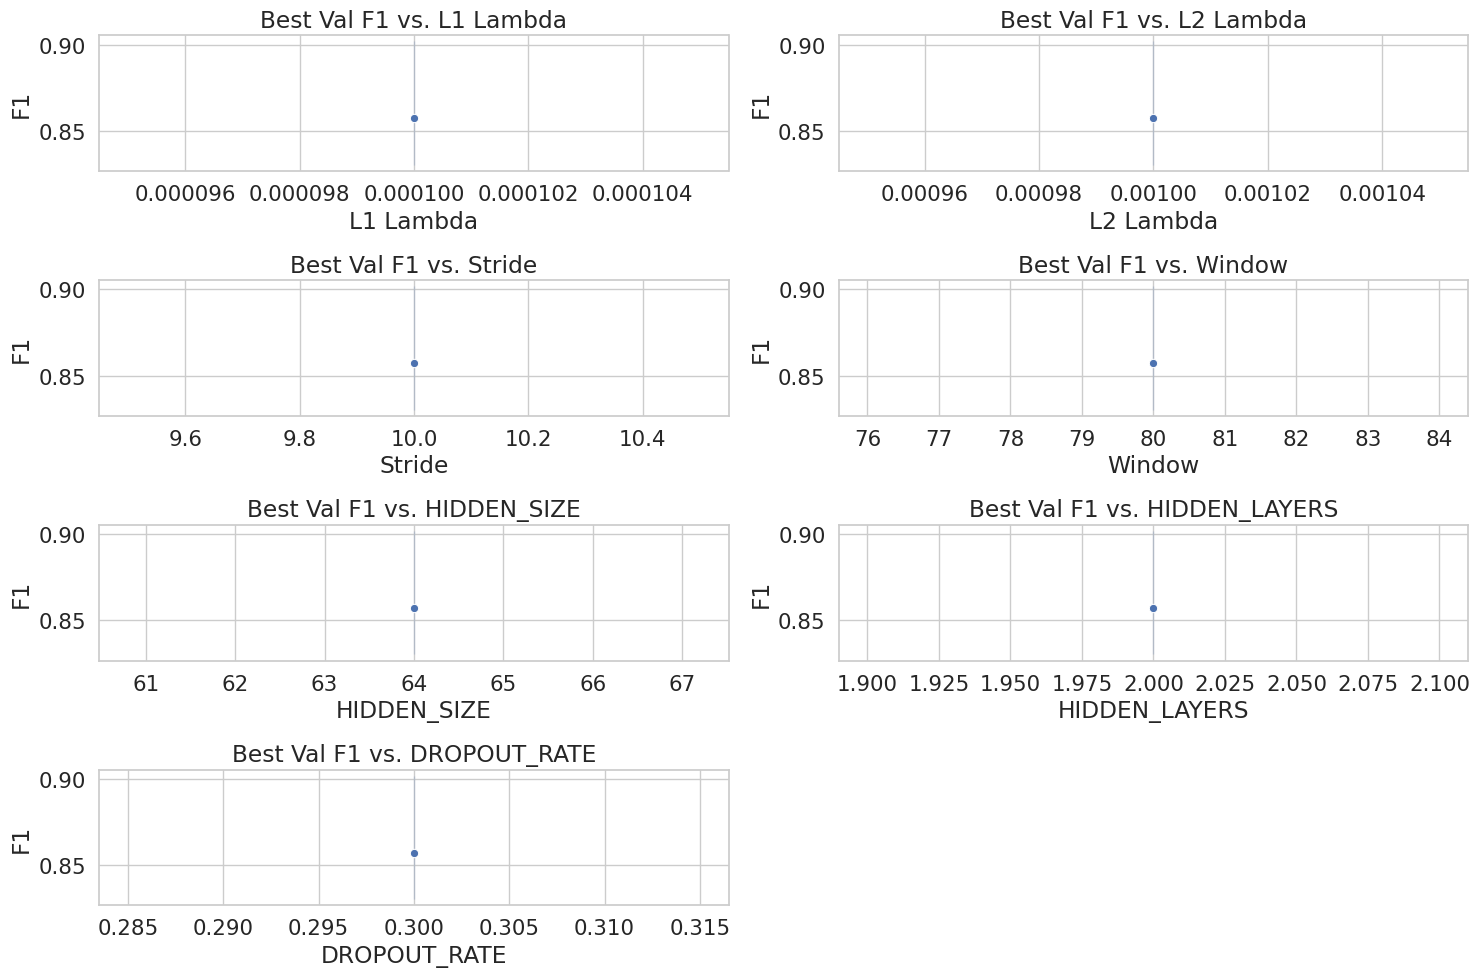

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")
plt.figure(figsize=(15, 10))

# Plot 1: Best_Val_F1 vs. L1_LAMBDA
plt.subplot(4, 2, 1)
sns.lineplot(data=results, x='L1_LAMBDA', y='Best_Val_F1', marker='o')
plt.title('Best Val F1 vs. L1 Lambda')
plt.xlabel('L1 Lambda')
plt.ylabel('F1')

# Plot 2: Best_Val_F1 vs. L2_LAMBDA
plt.subplot(4, 2, 2)
sns.lineplot(data=results, x='L2_LAMBDA', y='Best_Val_F1', marker='o')
plt.title('Best Val F1 vs. L2 Lambda')
plt.xlabel('L2 Lambda')
plt.ylabel('F1')

# Plot 3: Best_Val_F1 vs. STRIDE
plt.subplot(4, 2, 3)
sns.lineplot(data=results, x='STRIDE', y='Best_Val_F1', marker='o')
plt.title('Best Val F1 vs. Stride')
plt.xlabel('Stride')
plt.ylabel('F1')

# Plot 4: Best_Val_F1 vs. WINDOW
plt.subplot(4, 2, 4)
sns.lineplot(data=results, x='WINDOW', y='Best_Val_F1', marker='o')
plt.title('Best Val F1 vs. Window')
plt.xlabel('Window')
plt.ylabel('F1')

# Plot 5: Best_Val_F1 vs. Hidden Size
plt.subplot(4, 2, 5)
sns.lineplot(data=results, x='HIDDEN_SIZE', y='Best_Val_F1', marker='o')
plt.title('Best Val F1 vs. HIDDEN_SIZE')
plt.xlabel('HIDDEN_SIZE')
plt.ylabel('F1')

# Plot 6: Best_Val_F1 vs. L1_LAMBDA
plt.subplot(4, 2, 6)
sns.lineplot(data=results, x='HIDDEN_LAYERS', y='Best_Val_F1', marker='o')
plt.title('Best Val F1 vs. HIDDEN_LAYERS')
plt.xlabel('HIDDEN_LAYERS')
plt.ylabel('F1')

# Plot 7: Best_Val_F1 vs. L1_LAMBDA
plt.subplot(4, 2, 7)
sns.lineplot(data=results, x='DROPOUT_RATE', y='Best_Val_F1', marker='o')
plt.title('Best Val F1 vs. DROPOUT_RATE')
plt.xlabel('DROPOUT_RATE')
plt.ylabel('F1')

plt.tight_layout()
plt.show()